In [1]:
from glob import glob

from datasets import load_dataset
from sal.utils.math import *
from sal.utils.grader import *

from sal.utils.qwen_math_parser import *
from sal.utils.data import get_dataset, save_dataset
from collections import defaultdict
import json
import numpy as np
import pickle
from sal.config import Config

import os

/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/sal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config()
gt = get_dataset(config)

In [3]:
def is_correct(sample, key):
    ans = memoized_canonical_form(sample['answer'])
    pred = memoized_canonical_form(sample[f'pred_{key}']).strip("\\boxed{").strip("}")

    sample['is_correct_' + key] = math_equal(ans, pred)
    return sample


def parse_responses(sample):
    sample['parsed_responses'] = [strip_string(extract_answer(x, 'math')) for x in sample['completions']]
    return sample


def extract(string):
    return strip_string(extract_answer(string, 'math'))

In [4]:
data = load_dataset('json', data_files='outputs/kheuton_Qwen2.5-1.5B-Instruct-bon-completions-custom_combined.json')['train']

Generating train split: 475 examples [00:03, 124.56 examples/s]


In [5]:
from tqdm import tqdm
from collections import defaultdict

# Define the number of completions to evaluate (powers of 2)
n_completions = [2**i for i in range(8)]  # [1, 2, 4, 8, 16, 32, 64, 128]

results = []
best_of_n_accuracies = {}
weighted_best_of_n_accuracies = {}

# Convert datasets to dictionaries keyed by unique_id for faster lookup
gt_dict = {item['unique_id']: item for item in gt}
data_dict = {item['unique_id']: item for item in data}

# Find common unique_ids
common_ids = set(gt_dict.keys()) & set(data_dict.keys())

for unique_id in tqdm(common_ids, desc="Processing"):
    gt_sample = gt_dict[unique_id]
    data_sample = data_dict[unique_id]
    
    # Extract answers from all completions
    extracted_answers = [extract(completion) for completion in data_sample['completions']]
    scores = np.array(data_sample['scores'])
    
    # Store results for this sample
    sample_result = {
        'unique_id': unique_id,
        'gt_answer': gt_sample['answer'],
        'extracted_answers': extracted_answers,
        'scores': scores,
        'best_of_n_correct': {},
        'weighted_best_of_n_correct': {}
    }
    
    # Calculate best-of-n and weighted best-of-n for each n
    for n in n_completions:
        if n > len(extracted_answers):
            # If we don't have enough completions, use all available
            n_actual = len(extracted_answers)
        else:
            n_actual = n
            
        # Best-of-n: select the answer with highest score among first n completions
        best_idx = np.argmax(scores[:n_actual])
        best_answer = extracted_answers[best_idx]
        
        is_correct_best_of_n = math_equal(
            memoized_canonical_form(gt_sample['answer']), 
            memoized_canonical_form(best_answer)
        )
        sample_result['best_of_n_correct'][n] = is_correct_best_of_n
        
        # Weighted best-of-n: group by equivalent answers and sum scores
        answer_scores = defaultdict(float)
        for i in range(n_actual):
            canonical_answer = memoized_canonical_form(extracted_answers[i])
            answer_scores[canonical_answer] += scores[i]
        
        # Select answer with highest combined score
        best_weighted_answer = max(answer_scores.keys(), key=lambda x: answer_scores[x])
        
        is_correct_weighted = math_equal(
            memoized_canonical_form(gt_sample['answer']), 
            best_weighted_answer
        )
        sample_result['weighted_best_of_n_correct'][n] = is_correct_weighted
    
    results.append(sample_result)

# Calculate overall accuracies for each n
for n in n_completions:
    best_of_n_correct = sum(1 for r in results if r['best_of_n_correct'].get(n, False))
    weighted_best_of_n_correct = sum(1 for r in results if r['weighted_best_of_n_correct'].get(n, False))
    
    best_of_n_accuracies[n] = best_of_n_correct / len(results)
    weighted_best_of_n_accuracies[n] = weighted_best_of_n_correct / len(results)

print("Best-of-n accuracies:")
for n in n_completions:
    print(f"  n={n:3d}: {best_of_n_accuracies[n]:.2%}")

print("\nWeighted best-of-n accuracies:")
for n in n_completions:
    print(f"  n={n:3d}: {weighted_best_of_n_accuracies[n]:.2%}")


Processing: 100%|██████████| 475/475 [06:56<00:00,  1.14it/s]

Best-of-n accuracies:
  n=  1: 25.26%
  n=  2: 30.74%
  n=  4: 35.79%
  n=  8: 39.16%
  n= 16: 39.79%
  n= 32: 40.84%
  n= 64: 40.00%
  n=128: 34.53%

Weighted best-of-n accuracies:
  n=  1: 25.26%
  n=  2: 30.74%
  n=  4: 37.68%
  n=  8: 44.63%
  n= 16: 49.89%
  n= 32: 54.11%
  n= 64: 58.32%
  n=128: 59.16%


In [9]:
# Print detailed results
print(f"Total samples evaluated: {len(results)}")
print(f"Total completions per sample: {len(data_dict[list(common_ids)[0]]['completions'])}")

print("\n" + "="*60)
print("BEST-OF-N ACCURACY RESULTS")
print("="*60)
for n in n_completions:
    print(f"Best-of-{n:3d}: {best_of_n_accuracies[n]:.4f} ({best_of_n_accuracies[n]:.2%})")

print("\n" + "="*60)
print("WEIGHTED BEST-OF-N ACCURACY RESULTS")
print("="*60)
for n in n_completions:
    print(f"Weighted best-of-{n:3d}: {weighted_best_of_n_accuracies[n]:.4f} ({weighted_best_of_n_accuracies[n]:.2%})")

print("\n" + "="*60)
print("IMPROVEMENT ANALYSIS")
print("="*60)
print("Improvement of weighted over regular best-of-n:")
for n in n_completions:
    improvement = weighted_best_of_n_accuracies[n] - best_of_n_accuracies[n]
    print(f"n={n:3d}: {improvement:+.4f} ({improvement/best_of_n_accuracies[n]*100:+.2f}%)")

Total samples evaluated: 500
Total completions per sample: 128

BEST-OF-N ACCURACY RESULTS
Best-of-  1: 0.2440 (24.40%)
Best-of-  2: 0.3040 (30.40%)
Best-of-  4: 0.3460 (34.60%)
Best-of-  8: 0.3640 (36.40%)
Best-of- 16: 0.4000 (40.00%)
Best-of- 32: 0.3960 (39.60%)
Best-of- 64: 0.3780 (37.80%)
Best-of-128: 0.3540 (35.40%)

WEIGHTED BEST-OF-N ACCURACY RESULTS
Weighted best-of-  1: 0.2440 (24.40%)
Weighted best-of-  2: 0.3040 (30.40%)
Weighted best-of-  4: 0.3600 (36.00%)
Weighted best-of-  8: 0.4100 (41.00%)
Weighted best-of- 16: 0.4840 (48.40%)
Weighted best-of- 32: 0.5260 (52.60%)
Weighted best-of- 64: 0.5540 (55.40%)
Weighted best-of-128: 0.5920 (59.20%)

IMPROVEMENT ANALYSIS
Improvement of weighted over regular best-of-n:
n=  1: +0.0000 (+0.00%)
n=  2: +0.0000 (+0.00%)
n=  4: +0.0140 (+4.05%)
n=  8: +0.0460 (+12.64%)
n= 16: +0.0840 (+21.00%)
n= 32: +0.1300 (+32.83%)
n= 64: +0.1760 (+46.56%)
n=128: +0.2380 (+67.23%)


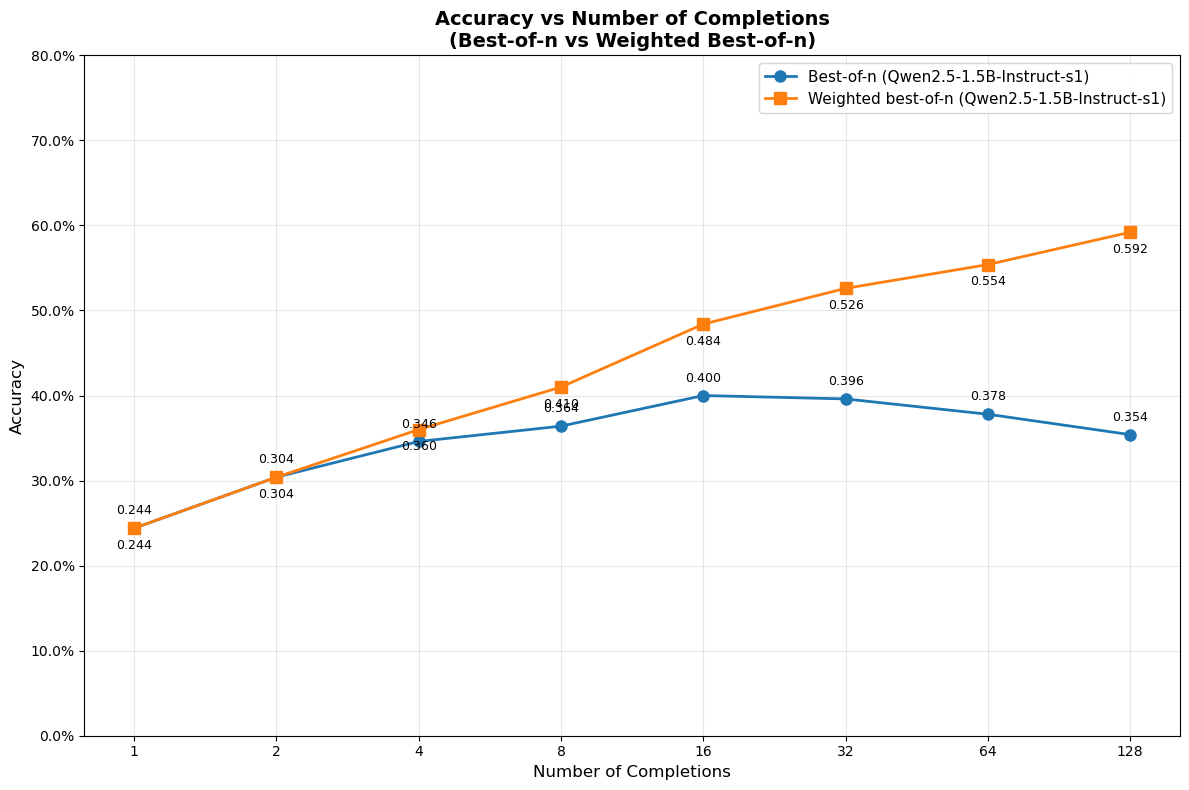

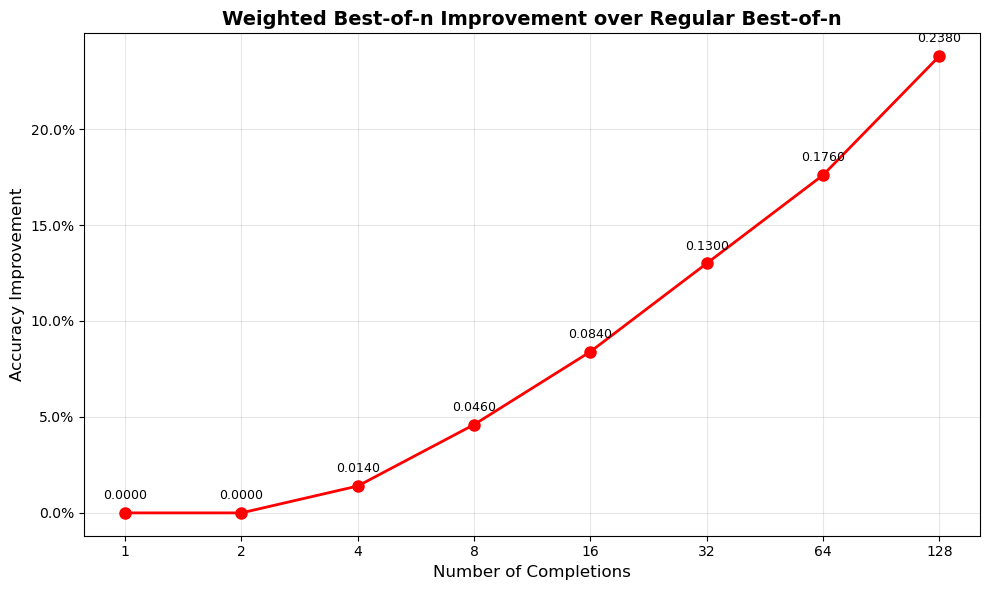

SUMMARY STATISTICS:
Best-of-1 accuracy: 0.2440
Best-of-128 accuracy: 0.3540
Best-of-n improvement (1→128): 0.1100
Weighted best-of-1 accuracy: 0.2440
Weighted best-of-128 accuracy: 0.5920
Weighted best-of-n improvement (1→128): 0.3480
Maximum weighted advantage: 0.2380 at n=128


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(12, 8))

# Extract data for plotting
x_values = n_completions
best_of_n_values = [best_of_n_accuracies[n] for n in n_completions]
weighted_best_of_n_values = [weighted_best_of_n_accuracies[n] for n in n_completions]

# Plot both lines
plt.plot(x_values, best_of_n_values, 'o-', label='Best-of-n (Qwen2.5-1.5B-Instruct-s1)', linewidth=2, markersize=8)
plt.plot(x_values, weighted_best_of_n_values, 's-', label='Weighted best-of-n (Qwen2.5-1.5B-Instruct-s1)', linewidth=2, markersize=8)

# Customize the plot
plt.xlabel('Number of Completions', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Number of Completions\n(Best-of-n vs Weighted Best-of-n)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Use log scale for x-axis since we're using powers of 2
plt.xscale('log', base=2)
plt.xticks(x_values, [str(x) for x in x_values])

# Set y-axis limit to 0.8
plt.ylim(0, 0.8)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Add value annotations
for i, (x, y1, y2) in enumerate(zip(x_values, best_of_n_values, weighted_best_of_n_values)):
    plt.annotate(f'{y1:.3f}', (x, y1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f'{y2:.3f}', (x, y2), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Also create a plot showing the improvement
plt.figure(figsize=(10, 6))
improvements = [weighted_best_of_n_accuracies[n] - best_of_n_accuracies[n] for n in n_completions]
plt.plot(x_values, improvements, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Completions', fontsize=12)
plt.ylabel('Accuracy Improvement', fontsize=12)
plt.title('Weighted Best-of-n Improvement over Regular Best-of-n', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks(x_values, [str(x) for x in x_values])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Add value annotations
for i, (x, y) in enumerate(zip(x_values, improvements)):
    plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("SUMMARY STATISTICS:")
print(f"Best-of-1 accuracy: {best_of_n_accuracies[1]:.4f}")
print(f"Best-of-128 accuracy: {best_of_n_accuracies[128]:.4f}")
print(f"Best-of-n improvement (1→128): {best_of_n_accuracies[128] - best_of_n_accuracies[1]:.4f}")
print(f"Weighted best-of-1 accuracy: {weighted_best_of_n_accuracies[1]:.4f}")
print(f"Weighted best-of-128 accuracy: {weighted_best_of_n_accuracies[128]:.4f}")
print(f"Weighted best-of-n improvement (1→128): {weighted_best_of_n_accuracies[128] - weighted_best_of_n_accuracies[1]:.4f}")
print(f"Maximum weighted advantage: {max(improvements):.4f} at n={x_values[np.argmax(improvements)]}")